# BIL 476: Veri Madenciliği - Proje "Market Basket Analysis"

##### Adı Soyadı: Hayrettin Kaan Özsoy
##### No: 201104086

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import random

from sklearn.utils import resample

from mlxtend.frequent_patterns import association_rules
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import fpgrowth

from sklearn.neighbors import NearestNeighbors
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore")

In [2]:
#data = pd.read_csv('data.csv')

ParserError: Error tokenizing data. C error: Expected 2 fields in line 111, saw 3


In [3]:
data = pd.read_csv('data.csv', error_bad_lines=False, warn_bad_lines=True)

Skipping line 111: expected 2 fields, saw 3
Skipping line 246: expected 2 fields, saw 3
Skipping line 948: expected 2 fields, saw 3
Skipping line 1006: expected 2 fields, saw 3
Skipping line 1075: expected 2 fields, saw 3
Skipping line 1206: expected 2 fields, saw 3
Skipping line 1207: expected 2 fields, saw 3
Skipping line 1249: expected 2 fields, saw 3
Skipping line 1633: expected 2 fields, saw 3
Skipping line 1688: expected 2 fields, saw 3
Skipping line 1712: expected 2 fields, saw 3
Skipping line 1713: expected 2 fields, saw 3
Skipping line 1719: expected 2 fields, saw 3
Skipping line 1720: expected 2 fields, saw 3
Skipping line 1891: expected 2 fields, saw 4
Skipping line 1919: expected 2 fields, saw 4
Skipping line 2059: expected 2 fields, saw 3
Skipping line 2060: expected 2 fields, saw 3
Skipping line 2061: expected 2 fields, saw 3
Skipping line 2062: expected 2 fields, saw 3
Skipping line 2063: expected 2 fields, saw 3
Skipping line 2096: expected 2 fields, saw 3
Skipping line

read_csv, error_bad_lines=False, warn_bad_lines=True parametreleri olmadan calistirildiginda asagidaki "Error tokenizing data" hatasi alinmisti.
Bu parametreler kullanilarak hatali satirlar tespit edildi. 

In [ ]:
"""

---------------------------------------------------------------------------
ParserError                               Traceback (most recent call last)
Cell In[7], line 1
----> 1 data = pd.read_csv('data.csv')

File c:\Users\kaan\anaconda3\lib\site-packages\pandas\util\_decorators.py:211, in deprecate_kwarg.<locals>._deprecate_kwarg.<locals>.wrapper(*args, **kwargs)
    209     else:
    210         kwargs[new_arg_name] = new_arg_value
--> 211 return func(*args, **kwargs)

File c:\Users\kaan\anaconda3\lib\site-packages\pandas\util\_decorators.py:331, in deprecate_nonkeyword_arguments.<locals>.decorate.<locals>.wrapper(*args, **kwargs)
    325 if len(args) > num_allow_args:
    326     warnings.warn(
    327         msg.format(arguments=_format_argument_list(allow_args)),
    328         FutureWarning,
    329         stacklevel=find_stack_level(),
    330     )
--> 331 return func(*args, **kwargs)

File c:\Users\kaan\anaconda3\lib\site-packages\pandas\io\parsers\readers.py:950, in read_csv(filepath_or_buffer, sep, delimiter, header, names, index_col, usecols, squeeze, prefix, mangle_dupe_cols, dtype, engine, converters, true_values, false_values, skipinitialspace, skiprows, skipfooter, nrows, na_values, keep_default_na, na_filter, verbose, skip_blank_lines, parse_dates, infer_datetime_format, keep_date_col, date_parser, dayfirst, cache_dates, iterator, chunksize, compression, thousands, decimal, lineterminator, quotechar, quoting, doublequote, escapechar, comment, encoding, encoding_errors, dialect, error_bad_lines, warn_bad_lines, on_bad_lines, delim_whitespace, low_memory, memory_map, float_precision, storage_options)
    935 kwds_defaults = _refine_defaults_read(
    936     dialect,
    937     delimiter,
   (...)
    946     defaults={"delimiter": ","},
...

File c:\Users\kaan\anaconda3\lib\site-packages\pandas\_libs\parsers.pyx:1973, in pandas._libs.parsers.raise_parser_error()

ParserError: Error tokenizing data. C error: Expected 2 fields in line 111, saw 3

"""

Bazi string degerleri virgul karakteri icerdigi icin hata aliniyor.

Ornegin "ELEPHANT, BIRTHDAY CARD,"
        "AIRLINE LOUNGE,METAL SIGN"

Bu durumu cozmek icin, veri seti satir satir incelenir.
Eger birinci kolondaki string degeri virgul iceriyorsa, virgul karakteri bosluk karakteri ile degistirilir.

In [4]:
file_path = 'data.csv'
rows = []

with open(file_path, 'r', encoding='utf-8') as file:
    for line in file:
        columns = line.strip().split(';')  # Satirdaki verileri ; ile ayir
        if ',' in columns[1]:
            columns[1] = columns[1].replace(',', ' ')  # Virgulleri bosluk ile degistir
        rows.append(columns)

data = pd.DataFrame(rows[1:], columns=rows[0])  # Ilk satir, oznitelik isimlerini icerir

Ornegin, BillNo: 568394 kaydina ait satirlardan birinde Itemname degeri virgul karakteri iceriyordu (SET 3 RETROSPOT TEA, COFFEE, SUGAR)

bosluk karakteri olarak guncellendi:

In [5]:
subset_data = data.iloc[348100:348110]
print(subset_data)

       ﻿BillNo                          Itemname Quantity              Date  \
348100  568393    EMBROIDERED RIBBON REEL CLAIRE        6  27.09.2011 10:12   
348101  568393     EMBROIDERED RIBBON REEL SUSIE        6  27.09.2011 10:12   
348102  568393     EMBROIDERED RIBBON REEL EMILY        6  27.09.2011 10:12   
348103  568393         SCANDINAVIAN REDS RIBBONS       12  27.09.2011 10:12   
348104  568394  SET 3 RETROSPOT TEA COFFEE SUGAR        4  27.09.2011 10:20   
348105  568394   PACK OF 72 RETROSPOT CAKE CASES       24  27.09.2011 10:20   
348106  568394     RED RETROSPOT ROUND CAKE TINS        1  27.09.2011 10:20   
348107  568394  SET OF 3 CAKE TINS PANTRY DESIGN        3  27.09.2011 10:20   
348108  568394         DAIRY MAID LARGE MILK JUG        3  27.09.2011 10:20   
348109  568394          BLUE VINTAGE SPOT BEAKER        8  27.09.2011 10:20   

       Price CustomerID         Country  
348100  3,75      15754  United Kingdom  
348101  2,08      15754  United Kingdom  
3481

In [6]:
random_sample = data.sample(n=10)

In [7]:
random_sample

,﻿BillNo,Itemname,Quantity,Date,Price,CustomerID,Country
294314,563709,RIBBON REEL STRIPES DESIGN,1,18.08.2011 15:17,"1,65",15472,United Kingdom
355151,569022,ROTATING SILVER ANGELS T-LIGHT HLDR,12,30.09.2011 09:45,"2,55",17725,United Kingdom
276812,562101,SET OF 36 DOILIES PANTRY DESIGN,12,2.08.2011 14:04,"1,45",13850,United Kingdom
276473,562046,GREEN POLKADOT BOWL,8,2.08.2011 10:34,"1,25",12378,Switzerland
86669,543909,TRAVEL SEWING KIT,1,14.02.2011 12:32,"3,29",,United Kingdom
96223,544771,EDWARDIAN PARASOL NATURAL,1,23.02.2011 11:12,"12,46",,United Kingdom
419452,574097,TRADITIONAL KNITTING NANCY,12,3.11.2011 09:56,"1,65",12471,Germany
110473,546008,MIRROR MOSAIC HURRICANE LAMP,1,8.03.2011 15:43,"4,96",,United Kingdom
436113,575477,CHILDRENS CUTLERY POLKADOT BLUE,1,9.11.2011 16:14,"8,29",,United Kingdom
264928,560930,12 PENCILS TALL TUBE POSY,24,22.07.2011 10:23,"0,29",15829,United Kingdom


## Veri Analizi

Duplicate satirlar kaldirilir, kontrol amacli DataFrame uzunlugu kontrol edilir.

In [8]:
print(len(data))
data.drop_duplicates(inplace=True)
print(len(data))

522064
516718


ValueError: invalid literal for int() with base 10: ''

CustomerID bilgisi bazi satirlarda eksik, onlari doldurmamiz gerek:

In [9]:
data['CustomerID'] = data['CustomerID'].replace('', np.nan)

Ozniteliklerin turleri incelenir.

In [10]:
column_types = data.dtypes

print(column_types)

BillNo       object
Itemname      object
Quantity      object
Date          object
Price         object
CustomerID    object
Country       object
dtype: object


### Veri tipi donusumleri

In [11]:
data['Date'] = pd.to_datetime(data['Date'])
data['Price'] = data['Price'].str.replace(',', '.').astype(float)
data.iloc[:, 2] = data.iloc[:, 2].astype(int)  # 2. kolon (Quantity)

In [ ]:
# data['BillNo'] = data['BillNo'].astype(int)
# data['CustomerID'] = data['CustomerID'].astype(int)

In [12]:
# Kolon adlari icerisinde gizli karakterler veya bosluklar bulunabilir, bunlar temizlenir.
data.columns = data.columns.str.strip()

# BillNo kolonundaki harf karakterleri kaldirilip sadece sayilari icermesi saglanir.
data.iloc[:, 0] = data.iloc[:, 0].astype(str).str.replace(r'\D', '', regex=True)

In [13]:
data.iloc[:, 0] = data.iloc[:, 0].astype(int)  # 0. kolon (BillNo)
data.iloc[:, 5] = data.iloc[:, 5].astype(float).astype('Int64')  # 5. kolon (CustomerID)

In [14]:
column_types = data.dtypes

print(column_types)

BillNo                int32
Itemname              object
Quantity               int32
Date          datetime64[ns]
Price                float64
CustomerID             Int64
Country               object
dtype: object


Quantity ve Price icin Filtreleme

In [15]:
data = data[(data['Quantity'] > 0) & (data['Price'] > 0)]

In [16]:
print(data.describe())
print("\n")
print(data.info())

             ﻿BillNo       Quantity          Price   CustomerID
count  514210.000000  514210.000000  514210.000000     382737.0
mean   559942.984318      10.474331       3.903558  15310.43058
std     13442.243136     157.801684      36.139248  1722.431296
min    536365.000000       1.000000       0.001000      12346.0
25%    547892.000000       1.000000       1.250000      13930.0
50%    560598.000000       3.000000       2.080000      15249.0
75%    571846.000000      10.000000       4.130000      16820.0
max    581587.000000   80995.000000   13541.330000      18287.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 514210 entries, 0 to 522063
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   ﻿BillNo     514210 non-null  int32         
 1   Itemname    514210 non-null  object        
 2   Quantity    514210 non-null  int32         
 3   Date        514210 non-null  datetime64[ns]
 4   Price       5

### Correlation Matrix

Bu veri setinde yer alan oznitelikler arasi iliskilere bakmak, Market Basket Analysis projemiz icin dogrudan ise yarar değildir. Genellikle ogelerin bir arada bulunma sikliklarini ve musteri alisveris aliskanliklarini incelemek daha mantikli olacaktir. Bu tur bir analizde, oznitelikler arasi korelasyonlar yerine, ogeler arasindaki iliskilere ve hangi ogelerin birlikte satin alindigina odaklanacagiz.

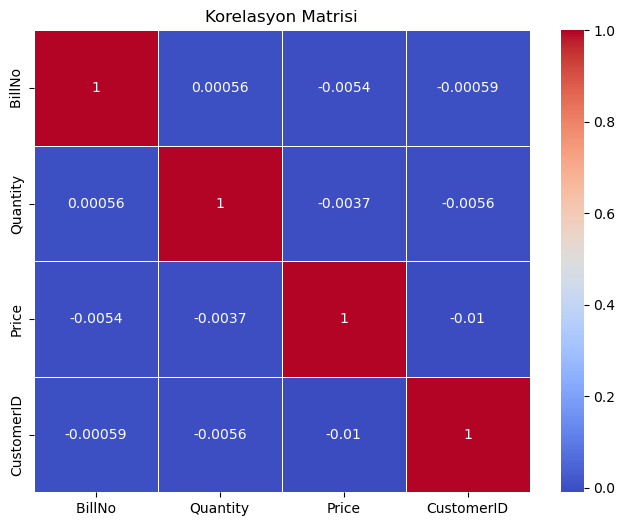

In [17]:
correlation_matrix = data.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Korelasyon Matrisi')
plt.show()

### "Country" Degerlerinin Dagilimi

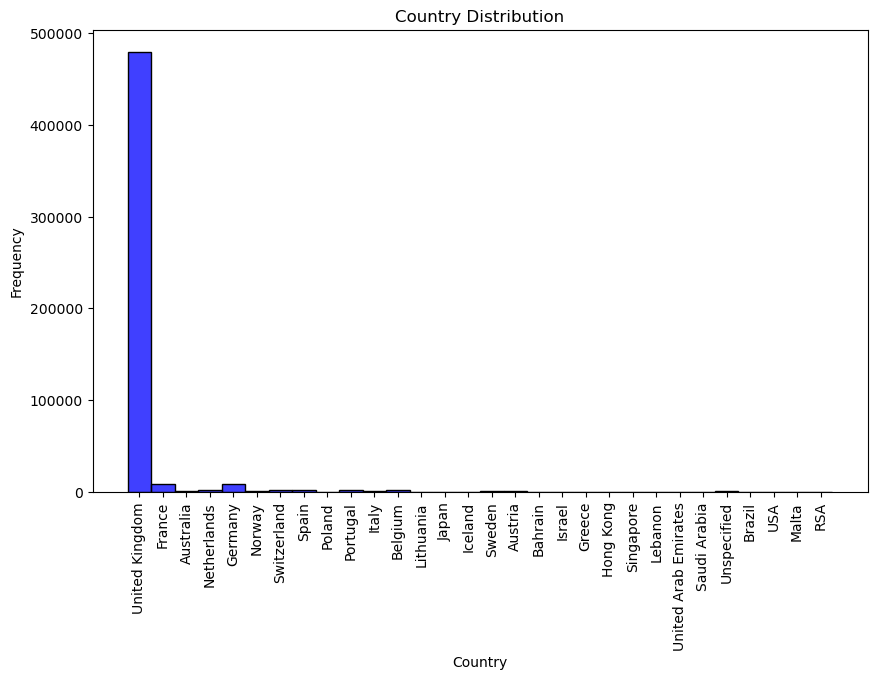

In [18]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Country'], kde=False, color='blue', bins=len(data['Country'].unique()))

# Grafik başlık ve etiketler
plt.title('Country Distribution')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show()

- "United Kingdom" verilerinin diger ulkelere kiyasla cok fazla olmasi veri setindeki dengesizligi gostermektedir.

- "Undersampling" islemi uygulanacaktir.

### Undersampling

Undersampling seviyesi, United Kingdom verilerinin, diger ulkelerin toplam veri sayisina indirilmesiyle gerceklestirilir.

Bu durumda, United Kingdom verilerinden rastgele bir alt kume secildi ve bu alt kumenin boyutu, diger ulkelerin toplam veri sayisina esit olacak sekilde ayarlandi.

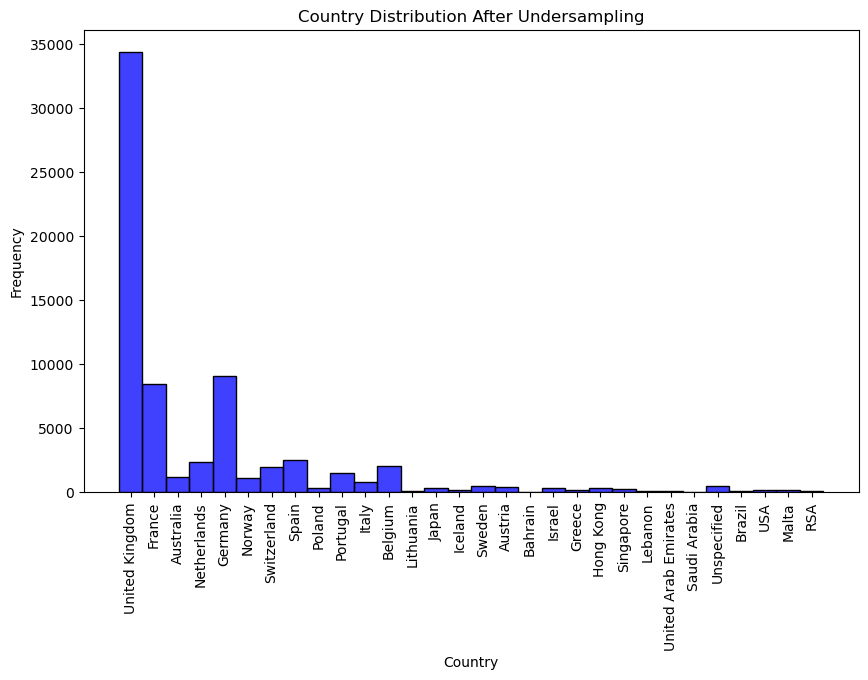

In [19]:
# United Kingdom verilerini ayirma
uk_data = data[data['Country'] == 'United Kingdom']
other_data = data[data['Country'] != 'United Kingdom']

# United Kingdom verilerini diger ulkelerle ayni sayida olacak sekilde kucultme
uk_data_downsampled = resample(uk_data, 
                               replace=False, 
                               n_samples=len(other_data), 
                               random_state=42)

# Kucultulmus veri setini birlestirme
balanced_data = pd.concat([uk_data_downsampled, other_data])

plt.figure(figsize=(10, 6))
sns.histplot(balanced_data['Country'], kde=False, color='blue', bins=len(balanced_data['Country'].unique()))
plt.title('Country Distribution After Undersampling')
plt.xlabel('Country')
plt.xticks(rotation=90)
plt.ylabel('Frequency')
plt.show()

Bu dengelenmis veriler, projenin "Discriminative Analysis" ve "Predictive Analysis" asamalarinda kullanilacaktir.

### En Sik Satilan Urunler

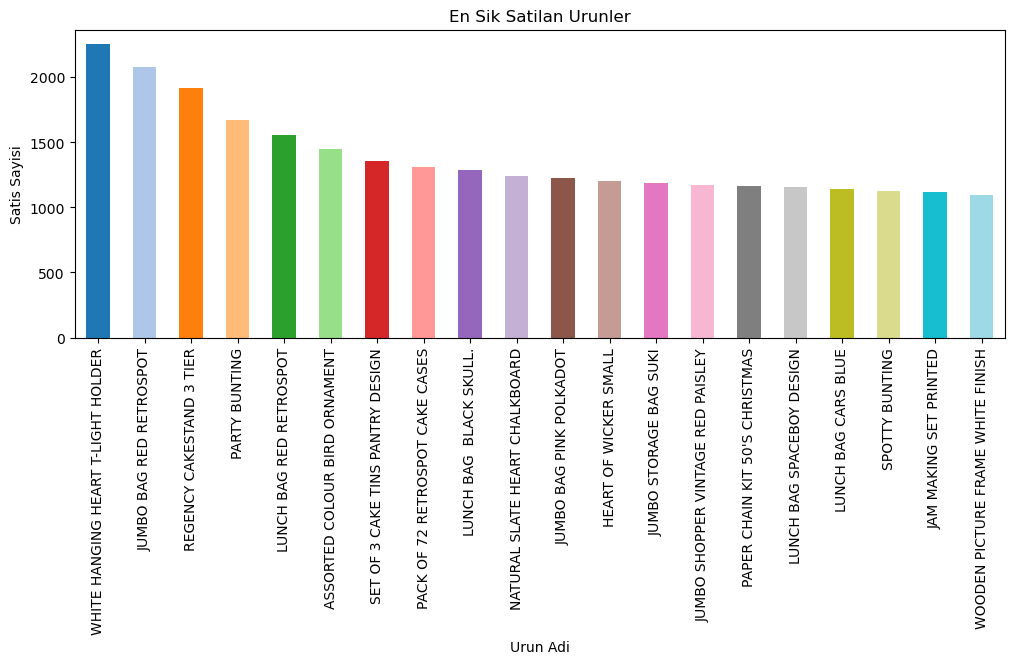

In [20]:
item_counts = data['Itemname'].value_counts().head(20)

colors = plt.cm.get_cmap('tab20', len(item_counts))

plt.figure(figsize=(12, 4))
item_counts.plot(kind='bar', color=[colors(i) for i in range(len(item_counts))])
plt.title('En Sik Satilan Urunler')
plt.xlabel('Urun Adi')
plt.ylabel('Satis Sayisi')
plt.show()

### Aylik Satislar

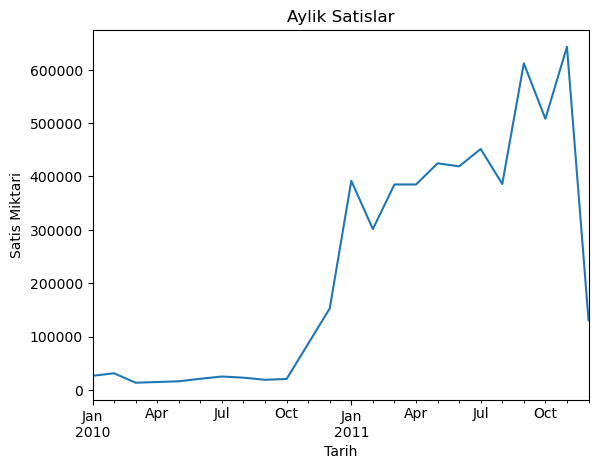

In [21]:
data['Month'] = data['Date'].dt.to_period('M')

# Aylık toplam satış miktarını hesaplama
monthly_sales = data.groupby('Month')['Quantity'].sum()

data.drop(columns=['Month'], inplace=True)

monthly_sales.plot()

plt.title('Aylik Satislar')
plt.xlabel('Tarih')
plt.ylabel('Satis Miktari')
plt.show()

## Descriptive Analysis

### Binarization

Kayitlari "BillNo" ve "Itemname" Ozniteliklerine Gore Gruplama

In [22]:
basket = data.groupby([data.columns[0], data.columns[1]])[data.columns[2]].sum().unstack().reset_index().fillna(0).set_index(data.columns[0])
# unstack sayesinde, her bir siparis bir satirda yer alir, her kolon bir urunun o sipariste ne kadar satildigini icerir.

In [23]:
basket

Itemname,"""ASSORTED FLOWER COLOUR """"LEIS""""""","""CHARLIE+LOLA""""EXTREMELY BUSY"""" SIGN""","""FLOWER GLASS GARLAND NECKL.36""""BLACK""","""FLOWER GLASS GARLAND NECKL.36""""BLUE""","""FLOWER GLASS GARLAND NECKL.36""""GREEN""","""FLOWER GLASS GARLD NECKL36""""AMETHYST""","""FLOWER GLASS GARLD NECKL36""""TURQUOIS""","""LETTER """"A"""" BLING KEY RING""","""LETTER """"B"""" BLING KEY RING""","""LETTER """"C"""" BLING KEY RING""",...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
﻿BillNo,,,,,,,,,,,,,,,,,,,,,
536365,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536366,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536368,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
536369,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581584,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
581585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,12.0,0.0,0.0,0.0,24.0,0.0,0.0


#### One-hot Encoding

In [24]:
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

In [25]:
basket

Itemname,"""ASSORTED FLOWER COLOUR """"LEIS""""""","""CHARLIE+LOLA""""EXTREMELY BUSY"""" SIGN""","""FLOWER GLASS GARLAND NECKL.36""""BLACK""","""FLOWER GLASS GARLAND NECKL.36""""BLUE""","""FLOWER GLASS GARLAND NECKL.36""""GREEN""","""FLOWER GLASS GARLD NECKL36""""AMETHYST""","""FLOWER GLASS GARLD NECKL36""""TURQUOIS""","""LETTER """"A"""" BLING KEY RING""","""LETTER """"B"""" BLING KEY RING""","""LETTER """"C"""" BLING KEY RING""",...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
﻿BillNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581585,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


### Apriori

In [26]:
#frequent_itemsets_apriori = apriori(basket, min_support=0.01, use_colnames=True)

MemoryError: Unable to allocate 96.0 GiB for an array with shape (329266, 2, 19559) and data type int64

In [27]:
frequent_itemsets_apriori = apriori(basket, min_support=0.05, use_colnames=True)

In [28]:
# Kurallari cikar
rules_apriori = association_rules(frequent_itemsets_apriori, metric="lift", min_threshold=1)
rules_apriori.sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric


In [29]:
frequent_itemsets_apriori = apriori(basket, min_support=0.01, use_colnames=True, low_memory=True)

low_memory=True parametresi kullanilmadiginda asagidaki hata alindi:

MemoryError: Unable to allocate 96.0 GiB for an array with shape (329266, 2, 19559) and data type int64

- min_support deger 0.01 olarak belirlendigi icin algoritma, cok fazla oge kumesini analiz etmekte ve bellek kullanimi artmaktadir.

- min_support degeri 0.05 secildiginde daha az oge kumesi analiz edilir ve bellek kullanimi azalir, fakat buyuk bir veri setine sahip oldugumuz icin ogelerin support degerleri dusuktur ve 0.01 civarinda dagilim gosterir.

- low_memory = True parametresi, Apriori algoritmasinin bellek kullanimini optimize eder. Veri kumesinin parcalar halinde islenmesini ssglayarak bellek tuketimini azaltir.

#### Association Rules

In [30]:
# Kurallari cikar
rules_apriori = association_rules(frequent_itemsets_apriori, metric="lift", min_threshold=1)

In [31]:
rules_apriori.sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
2175,(HERB MARKER THYME),"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",0.011913,0.010737,0.010225,0.858369,79.946863,0.010098,6.984798,0.999397
2174,"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",(HERB MARKER THYME),0.010737,0.011913,0.010225,0.952381,79.946863,0.010098,20.749834,0.998209
2176,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER PARSLEY)",0.011964,0.010737,0.010225,0.854701,79.605210,0.010097,6.808459,0.999395
2173,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010737,0.011964,0.010225,0.952381,79.605210,0.010097,20.748760,0.998155
2170,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER BASIL)",0.011964,0.010532,0.010021,0.837607,79.527923,0.009895,6.093038,0.999382
2167,"(HERB MARKER THYME, HERB MARKER BASIL)",(HERB MARKER ROSEMARY),0.010532,0.011964,0.010021,0.951456,79.527923,0.009895,20.353546,0.997936
2168,"(HERB MARKER ROSEMARY, HERB MARKER BASIL)",(HERB MARKER THYME),0.010686,0.011913,0.010021,0.937799,78.722796,0.009894,15.885404,0.997961
2169,(HERB MARKER THYME),"(HERB MARKER ROSEMARY, HERB MARKER BASIL)",0.011913,0.010686,0.010021,0.841202,78.722796,0.009894,6.230007,0.999200
549,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.011964,0.011913,0.011095,0.927350,77.845695,0.010952,13.600731,0.999107
548,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011913,0.011964,0.011095,0.931330,77.845695,0.010952,14.388277,0.999055


### FP-Growth

In [32]:
frequent_itemsets_fp_growth = fpgrowth(basket, min_support=0.01, use_colnames=True)

#### Association Rules

In [33]:
rules_fp_growth = association_rules(frequent_itemsets_fp_growth, metric="lift", min_threshold=1)

# Lift degeri en yuksek ilk 10 kural
rules_fp_growth.sort_values('lift', ascending=False).head(10)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1671,(HERB MARKER THYME),"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",0.011913,0.010737,0.010225,0.858369,79.946863,0.010098,6.984798,0.999397
1670,"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",(HERB MARKER THYME),0.010737,0.011913,0.010225,0.952381,79.946863,0.010098,20.749834,0.998209
1672,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER PARSLEY)",0.011964,0.010737,0.010225,0.854701,79.605210,0.010097,6.808459,0.999395
1669,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010737,0.011964,0.010225,0.952381,79.605210,0.010097,20.748760,0.998155
1655,"(HERB MARKER THYME, HERB MARKER BASIL)",(HERB MARKER ROSEMARY),0.010532,0.011964,0.010021,0.951456,79.527923,0.009895,20.353546,0.997936
1658,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER BASIL)",0.011964,0.010532,0.010021,0.837607,79.527923,0.009895,6.093038,0.999382
1656,"(HERB MARKER ROSEMARY, HERB MARKER BASIL)",(HERB MARKER THYME),0.010686,0.011913,0.010021,0.937799,78.722796,0.009894,15.885404,0.997961
1657,(HERB MARKER THYME),"(HERB MARKER ROSEMARY, HERB MARKER BASIL)",0.011913,0.010686,0.010021,0.841202,78.722796,0.009894,6.230007,0.999200
1649,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.011964,0.011913,0.011095,0.927350,77.845695,0.010952,13.600731,0.999107
1648,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011913,0.011964,0.011095,0.931330,77.845695,0.010952,14.388277,0.999055


In [34]:
# DataFrame'leri hucre hucre karsilastirma
comparison = rules_apriori == rules_fp_growth

similarity_percentage = comparison.values.sum() / comparison.size * 100
print(f"DataFrame'ler {similarity_percentage:.2f} oraninda benzer.")

DataFrame'ler 0.89 oraninda benzer.


Goruldugu uzere, FP-Growth genellikle buyuk veriler uzerinde daha hizli calisir, bellek kullanimi acisindan da daha verimlidir.

#### Lift degeri yuksek ilk 20 kural

Lift degeri, iki oge kumesi arasindaki bagimsizlik derecesini gosterir. Birlikte gorulme olasiliginin, bagimsiz gorulme olasiligina oranina esittir. Lift degeri 1'den buyukse, iki oge arasinda pozitif bir iliski vardir; 1'den kucukse, negatif bir iliski vardir.

In [35]:
top_rules = rules_fp_growth.sort_values('lift', ascending=False).head(20)

In [36]:
top_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
1671,(HERB MARKER THYME),"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",0.011913,0.010737,0.010225,0.858369,79.946863,0.010098,6.984798,0.999397
1670,"(HERB MARKER ROSEMARY, HERB MARKER PARSLEY)",(HERB MARKER THYME),0.010737,0.011913,0.010225,0.952381,79.946863,0.010098,20.749834,0.998209
1672,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER PARSLEY)",0.011964,0.010737,0.010225,0.854701,79.605210,0.010097,6.808459,0.999395
1669,"(HERB MARKER THYME, HERB MARKER PARSLEY)",(HERB MARKER ROSEMARY),0.010737,0.011964,0.010225,0.952381,79.605210,0.010097,20.748760,0.998155
1655,"(HERB MARKER THYME, HERB MARKER BASIL)",(HERB MARKER ROSEMARY),0.010532,0.011964,0.010021,0.951456,79.527923,0.009895,20.353546,0.997936
1658,(HERB MARKER ROSEMARY),"(HERB MARKER THYME, HERB MARKER BASIL)",0.011964,0.010532,0.010021,0.837607,79.527923,0.009895,6.093038,0.999382
1656,"(HERB MARKER ROSEMARY, HERB MARKER BASIL)",(HERB MARKER THYME),0.010686,0.011913,0.010021,0.937799,78.722796,0.009894,15.885404,0.997961
1657,(HERB MARKER THYME),"(HERB MARKER ROSEMARY, HERB MARKER BASIL)",0.011913,0.010686,0.010021,0.841202,78.722796,0.009894,6.230007,0.999200
1649,(HERB MARKER ROSEMARY),(HERB MARKER THYME),0.011964,0.011913,0.011095,0.927350,77.845695,0.010952,13.600731,0.999107
1648,(HERB MARKER THYME),(HERB MARKER ROSEMARY),0.011913,0.011964,0.011095,0.931330,77.845695,0.010952,14.388277,0.999055


### "Support, Confidence, Lift" Iliskileri

<Axes: xlabel='antecedent support', ylabel='consequent support'>

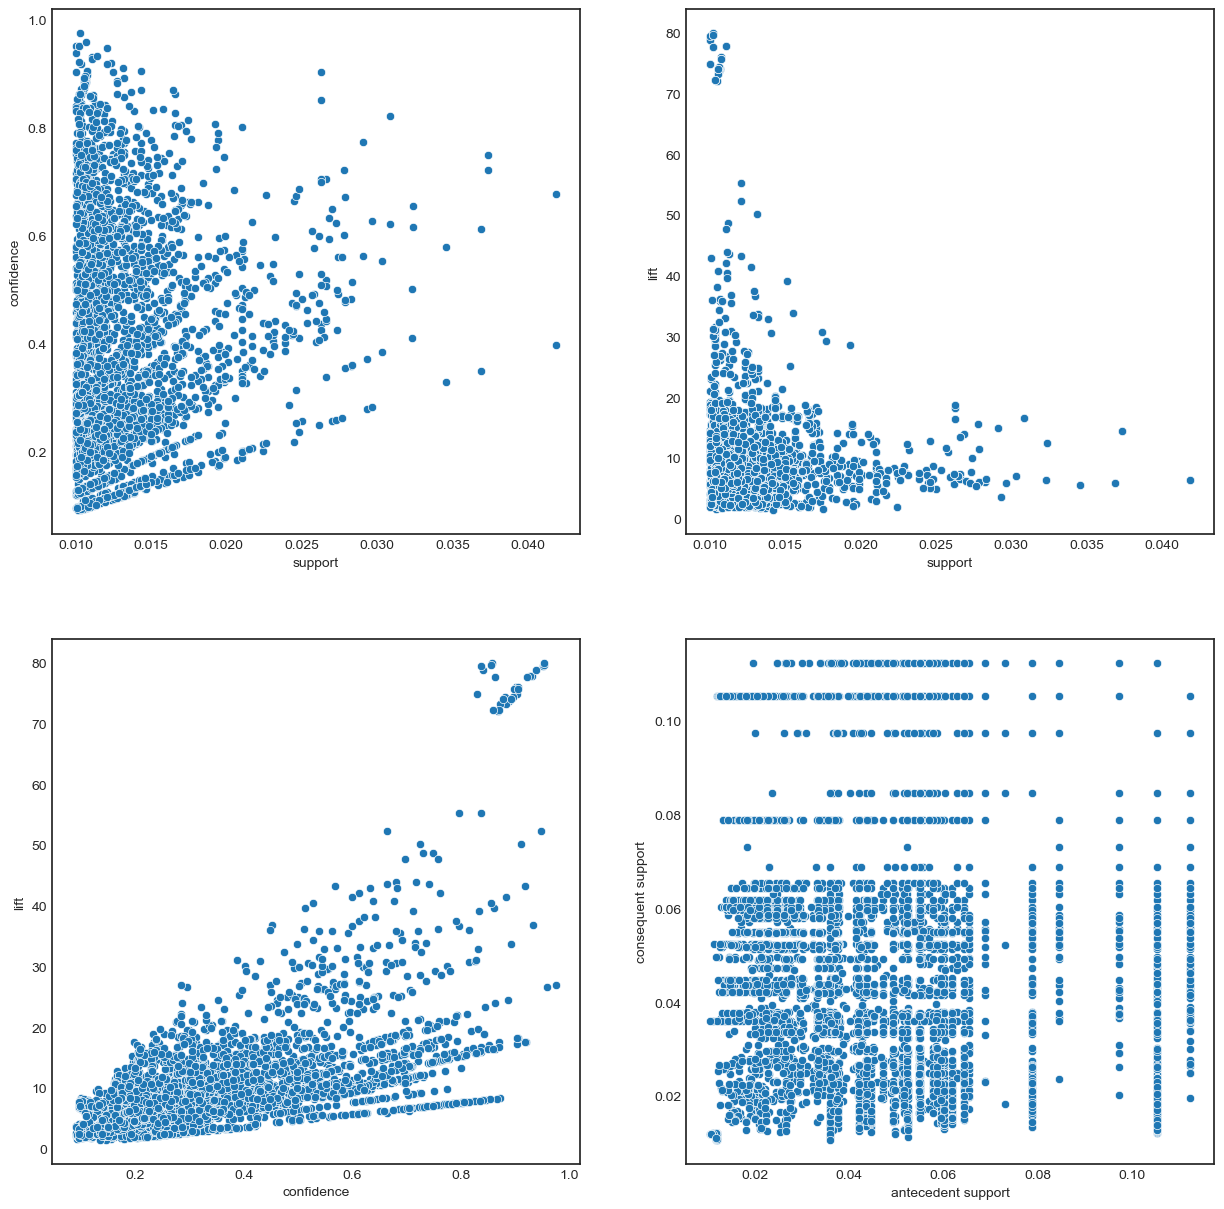

In [37]:
#Setting up the style
plt.figure(figsize = (15, 15))
plt.style.use('seaborn-white')
#Plotting the relationship between the metrics
plt.subplot(221)
sns.scatterplot(x="support", y="confidence",data=rules_fp_growth)
plt.subplot(222)
sns.scatterplot(x="support", y="lift",data=rules_fp_growth)
plt.subplot(223)
sns.scatterplot(x="confidence", y="lift",data=rules_fp_growth)
plt.subplot(224)
sns.scatterplot(x="antecedent support", y="consequent support",data=rules_fp_growth)

- Support-Confidence Grafigi:
Dusuk support degerlerinde, confidence degerleri genis bir aralikta degismektedir. Yani, nadir gorulen kombinasyonlar bazen cok guvenilir olurken bazen de olmayacaktir. Yuksek support degerlerinde gorulen kombinasyonlar genelde daha guvenilirdir (yuksek confidence).

- Support-Lift Grafigi: 
Dusuk support degerlerinde lift, genis bir dagilim araligina sahipken yuksek support degerlerinde, daha dusuk olmaktadir. 

- Confidence-Lift Grafigi:
Bu iki degisken arasinda pozitif bir iliski gozlemlenir, daha guvenilir (yuksek confidence) kurallarin daha anlamli (yuksek lift) olabilecegi soylenebilir.

- Antecedent Support-Consequent Support Grafigi:
Bu degerler arasinda dogrusal bir iliski gozlemlenmemektedir. 

#### Heatmap (Lift)

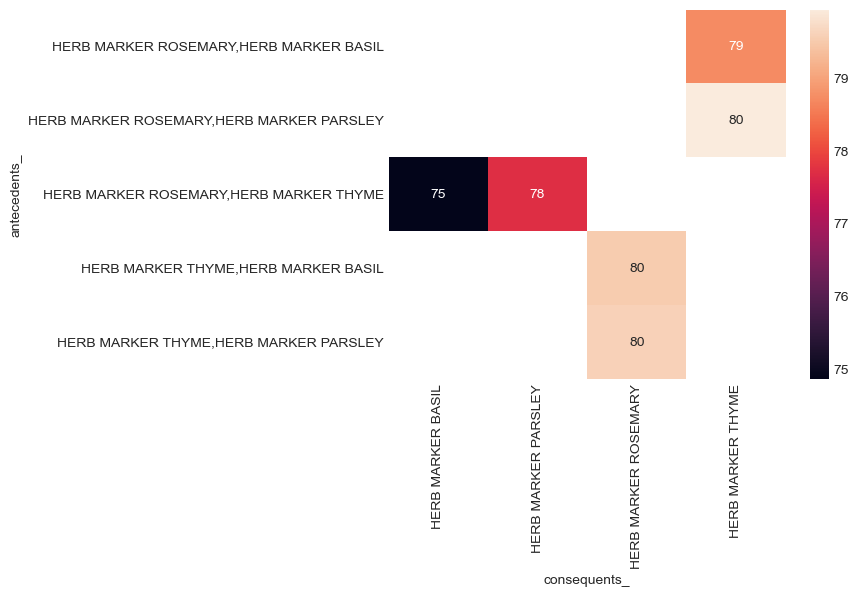

In [38]:
top_rules['lhs_items'] = top_rules['antecedents'].apply(lambda x:len(x) )
top_rules[top_rules['lhs_items']>1].sort_values('lift', ascending=False).head()
top_rules['antecedents_'] = top_rules['antecedents'].apply(lambda a: ','.join(list(a)))
top_rules['consequents_'] = top_rules['consequents'].apply(lambda a: ','.join(list(a)))
pivot = top_rules[top_rules['lhs_items']>1].pivot(index = 'antecedents_', columns = 'consequents_', values= 'lift')
sns.heatmap(pivot, annot = True)
plt.yticks(rotation=0)
plt.xticks(rotation=90)
plt.show()

#### Lift degerleri iliskisi

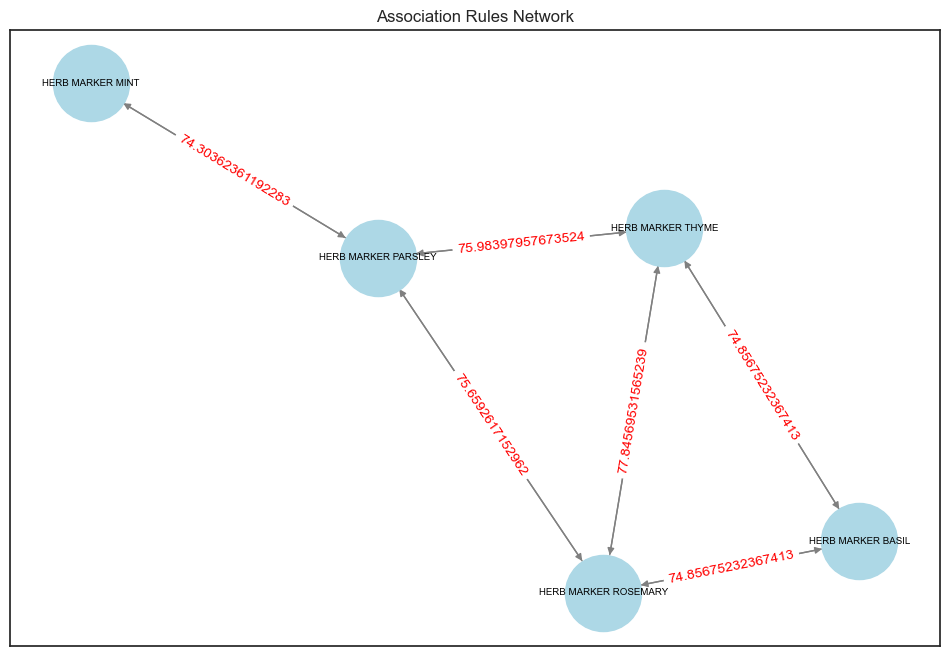

In [39]:
def draw_graph(rules, rules_to_show):
    G = nx.DiGraph()

    for i in range(rules_to_show):
        rule = rules.iloc[i]
        for antecedent in rule['antecedents']:
            for consequent in rule['consequents']:
                G.add_edge(antecedent, consequent, weight=rule['lift'])

    pos = nx.spring_layout(G)
    plt.figure(figsize=(12, 8))
    nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=3000, font_size=7)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title('Association Rules Network')
    plt.show()

# Ilk 20 kurali cizdir
draw_graph(top_rules, 20)

#### Yalnizca Lift degeri en yuksek iliskileri degil, baska Lift degeri araliklarindaki iliskileri de gorsellestirelim:

In [40]:
# rules uzunlugunun en az 20 oldugu varsayildi
start_index = random.randint(0, len(rules_fp_growth) - 21)
end_index = start_index + 20

# Secilen araliktaki kurallari filtrele
selected_rules = rules_fp_growth.sort_values('lift', ascending=False).iloc[start_index:end_index]

selected_rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
535,"(WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE ...","(CHARLOTTE BAG PINK POLKADOT, RED RETROSPOT CH...",0.020655,0.026586,0.012322,0.596535,22.437733,0.011773,2.412633,0.975583
530,"(CHARLOTTE BAG PINK POLKADOT, RED RETROSPOT CH...","(WOODLAND CHARLOTTE BAG, STRAWBERRY CHARLOTTE ...",0.026586,0.020655,0.012322,0.463462,22.437733,0.011773,1.825302,0.981527
3361,(JUMBO BAG PEARS),"(JUMBO BAG APPLES, JUMBO BAG VINTAGE LEAF)",0.029961,0.018201,0.012219,0.407850,22.407682,0.011674,1.658023,0.984880
3356,"(JUMBO BAG APPLES, JUMBO BAG VINTAGE LEAF)",(JUMBO BAG PEARS),0.018201,0.029961,0.012219,0.671348,22.407682,0.011674,2.951573,0.973084
1533,(CHRISTMAS CRAFT LITTLE FRIENDS),(CHRISTMAS CRAFT TREE TOP ANGEL),0.027353,0.022649,0.013804,0.504673,22.281935,0.013185,1.973142,0.981981
1532,(CHRISTMAS CRAFT TREE TOP ANGEL),(CHRISTMAS CRAFT LITTLE FRIENDS),0.022649,0.027353,0.013804,0.609481,22.281935,0.013185,2.490651,0.977255
517,"(CHARLOTTE BAG PINK POLKADOT, RED RETROSPOT CH...","(CHARLOTTE BAG SUKI DESIGN, STRAWBERRY CHARLOT...",0.026586,0.021064,0.012475,0.469231,22.275934,0.011915,1.844371,0.981195
520,"(CHARLOTTE BAG SUKI DESIGN, STRAWBERRY CHARLOT...","(CHARLOTTE BAG PINK POLKADOT, RED RETROSPOT CH...",0.021064,0.026586,0.012475,0.592233,22.275934,0.011915,2.387181,0.975660
555,"(CHARLOTTE BAG PINK POLKADOT, CHARLOTTE BAG SU...",(STRAWBERRY CHARLOTTE BAG),0.012782,0.036607,0.010379,0.812000,22.181436,0.009911,5.124430,0.967281
582,(STRAWBERRY CHARLOTTE BAG),"(CHARLOTTE BAG PINK POLKADOT, CHARLOTTE BAG SU...",0.036607,0.012782,0.010379,0.283520,22.181436,0.009911,1.377872,0.991202


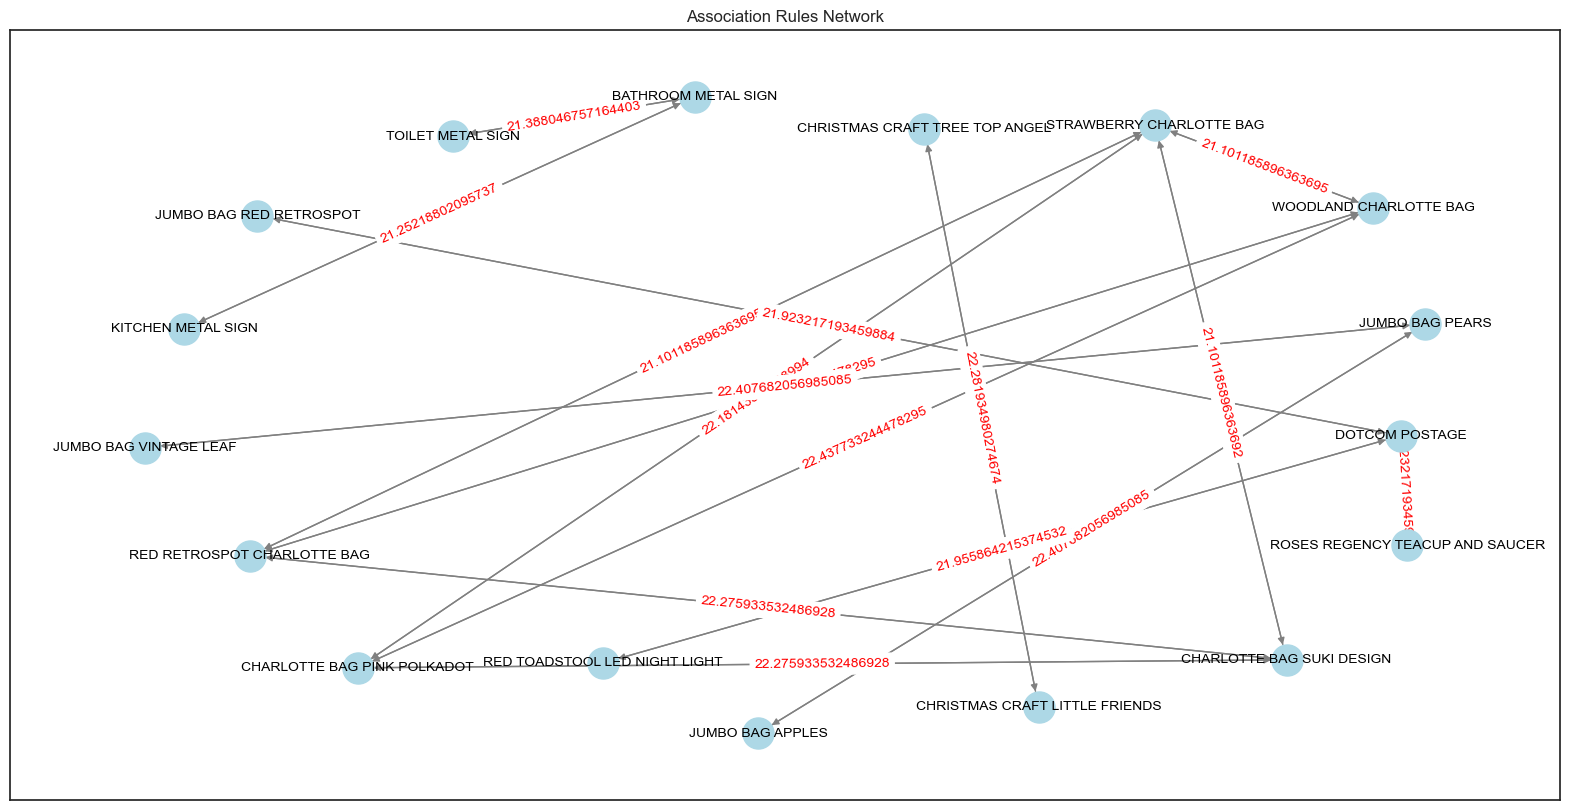

In [41]:
def draw_graph(rules, rules_to_show):
    G = nx.DiGraph()

    for i in range(rules_to_show):
        rule = rules.iloc[i]
        for antecedent in rule['antecedents']:
            for consequent in rule['consequents']:
                G.add_edge(antecedent, consequent, weight=rule['lift'])

    pos = nx.spring_layout(G, k=20, scale=1)
    plt.figure(figsize=(20, 10))
    nx.draw_networkx(G, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=500, font_size=10)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='red')
    plt.title('Association Rules Network')
    plt.show()

draw_graph(selected_rules, len(selected_rules))

Yukaridaki Network Graph'ta dugumler urunleri, kenarlar urunler arasi iliskiyi (lift) temsil etmektedir.

#### Support Degerlerinin Dagilimi

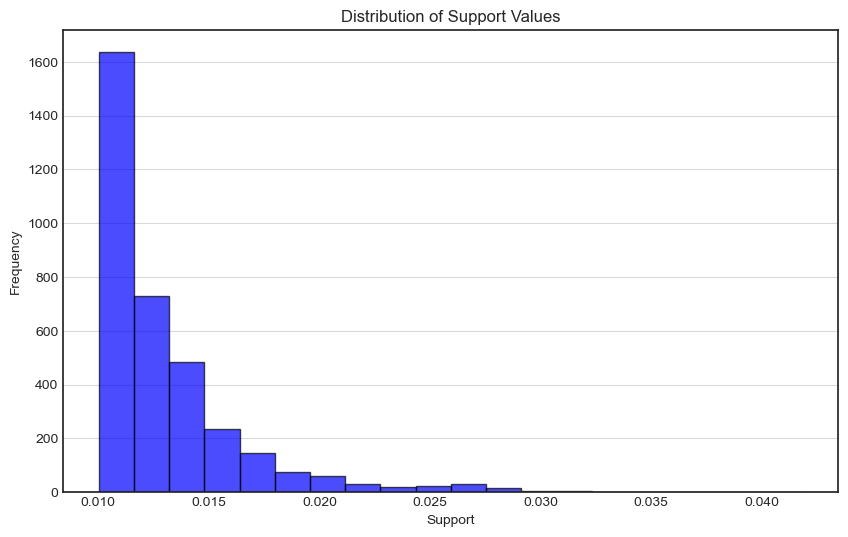

In [42]:
support_values = rules_fp_growth['support']

# Histogram çizimi
plt.figure(figsize=(10, 6))
plt.hist(support_values, bins=20, color='blue', edgecolor='black', alpha=0.7)
plt.title('Distribution of Support Values')
plt.xlabel('Support')
plt.ylabel('Frequency')
plt.grid(axis='y', alpha=0.75)
plt.show()

Support degerleri arttikca kural sayisinin hizla azaldigi gorulur. Cok az sayida kural, daha yuksek support degerine sahiptir. Yani, bu tur kurallar veri setinde daha sik gozlemlenen kurallari temsil eder.

### ECLAT

Veriyi ECLAT'in input formatina uygun hale getirme

In [ ]:
items=data.set_index([data.columns[0]]).stack()
item=pd.DataFrame(items)
item.rename(columns={0:'list'},inplace=True)

In [ ]:
item.index.levels[0]
# Her satirin belli bir siparise ait verileri icerdigi dogrulanir

In [ ]:
products=[]

for i in (item.index.levels[0]):
    product=item.loc[(i,['Itemname']),'list'].to_list()
    
    products.append(product)

In [ ]:
products = pd.DataFrame(products)

In [ ]:
products

In [ ]:
"""
from pyECLAT import ECLAT
from multiprocessing import Pool

def run_eclat(data_slice):
    eclat_instance = ECLAT(data=data_slice, verbose=True)
    rules = eclat_instance.fit(min_support=0.01, min_combination=1, max_combination=3)
    return rules

# Veri kumesini parcalara ayirma
data_slices = [products.iloc[i::4] for i in range(4)]

# Paralel processing pool olusturma
with Pool(processes=4) as pool:
    results = pool.map(run_eclat, data_slices)

# Sonuclari birlesir
final_rules = pd.concat(results)

print(final_rules)

"""

#eclat_instance = ECLAT(data=basket, verbose=True)
#rules = eclat_instance.fit(min_support=0.01, min_combination=1, max_combination=5)

Ekran görüntüsü:

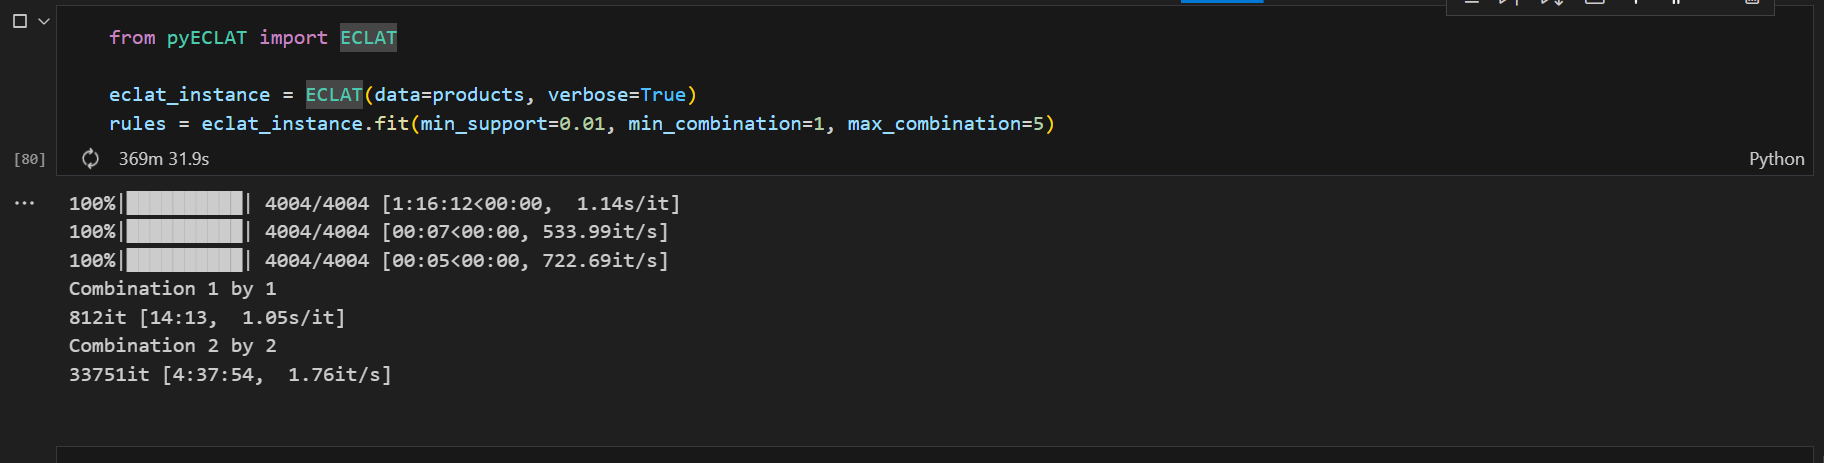

ECLAT algoritmasini uygularken ciddi performans sorunlari yasandi. Yukaridaki ekran goruntusundan de goruldugu uzere, yaklasik dort saat calismasina ragmen sonuclar elde edilememis ve islem durdurulmak zorunda kalinmistir.

Ayrica, parametre degisimleri yapilarak ve Multiprocessing islemleri uygulanarak islem gerceklestirilmek istendiginde yine ayni sorunlar gozlemlenmistir.

In [43]:
# Kuralların özetini yazdırma
print("Set of {} rules".format(len(rules_fp_growth)))
print("\nRule length distribution (lhs + rhs):\n")
print(rules_fp_growth['antecedents'].apply(lambda x: len(x)).value_counts().sort_index())
print("\nSummary of quality measures:\n")
print(rules_fp_growth[['support', 'confidence', 'lift', 'leverage', 'conviction']].describe())

# Kuralların genel özetini almak
summary = rules_fp_growth.describe()
print("\nSummary statistics of the rules:\n", summary)

# Ayrıca, her bir metrik için daha ayrıntılı özet bilgiler
print("\nSupport summary:\n", rules_fp_growth['support'].describe())
print("\nConfidence summary:\n", rules_fp_growth['confidence'].describe())
print("\nLift summary:\n", rules_fp_growth['lift'].describe())
print("\nCount summary:\n", rules_fp_growth['consequents'].apply(lambda x: len(x)).describe())

Set of 3500 rules

Rule length distribution (lhs + rhs):

1    2556
2     853
3      86
4       5
Name: antecedents, dtype: int64

Summary of quality measures:

           support   confidence         lift     leverage   conviction
count  3500.000000  3500.000000  3500.000000  3500.000000  3500.000000
mean      0.013007     0.374797    10.680365     0.011055     1.862543
std       0.003604     0.196331     9.301889     0.003414     1.544394
min       0.010021     0.090537     1.385628     0.003863     1.037890
25%       0.010634     0.218867     5.722016     0.009234     1.225323
50%       0.011862     0.322946     8.844801     0.010294     1.416418
75%       0.014009     0.510892    12.656899     0.012231     1.955746
max       0.041873     0.975728    79.946863     0.035349    39.712848

Summary statistics of the rules:
        antecedent support  consequent support      support   confidence  \
count         3500.000000         3500.000000  3500.000000  3500.000000   
mean           

- Support degerlerinin standart sapmasi dusuktur, bu durum kurallarin destek degerlerinin buyuk olcude birbirine yakin oldugunu gostermektedir.

- Confidence degerleri arasindaki varyasyon buyuktur.

- Lift degerlerinin ortalaması 10.68'dir, bu durum kurallarin, urunlerin bir arada satin alinma olasiligini on kat artirdigini gosterir.

## Predictive Analysis

Bu bolumde, K-Nearest Neighbors yaklasimi kullanilarak id'si verilen musterinin alabilecegi en olasi urunlerin listesi verilir.

In [44]:
basket_customer = balanced_data.groupby(['CustomerID', 'Itemname'])['Quantity'].sum().unstack().reset_index().fillna(0).set_index('CustomerID')
basket_customer = basket_customer.applymap(lambda x: 1 if x > 0 else 0)

In [45]:
basket_customer

Itemname,3D DOG PICTURE PLAYING CARDS,3D SHEET OF CAT STICKERS,3D SHEET OF DOG STICKERS,60 TEATIME FAIRY CAKE CASES,72 SWEETHEART FAIRY CAKE CASES,AIRLINE BAG VINTAGE JET SET BROWN,AIRLINE BAG VINTAGE JET SET RED,AIRLINE BAG VINTAGE JET SET WHITE,AIRLINE BAG VINTAGE TOKYO 78,AIRLINE BAG VINTAGE WORLD CHAMPION,...,MEDIUM CHINESE STYLE SCISSOR,CHRYSANTHEMUM POCKET BOOK,WALL ART VILLAGE SHOW,VINTAGE GLASS TEA CADDY,75 BLACK PETIT FOUR CASES,HANGING BAUBLE T-LIGHT HOLDER SMALL,SET OF 12 MINI BUNNIES IN A BUCKET,MINITURE ANTIQUE ROSE HOOK IVORY,WHITE MOROCCAN METAL LANTERN,RED PUDDING SPOON
CustomerID,,,,,,,,,,,,,,,,,,,,,
12347,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
12349,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12350,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12352,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12353,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18276,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18281,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18282,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
model = NearestNeighbors(metric='cosine', algorithm='brute')
model.fit(basket_customer)

NearestNeighbors(algorithm='brute', metric='cosine')

#### Customer ID'si verilen musteriye oneride bulunma

In [47]:
def get_recommendations(customer_id, n_recommendations=5):
    if customer_id in basket_customer.index:
        distances, indices = model.kneighbors(basket_customer.loc[customer_id].values.reshape(1, -1), n_neighbors=n_recommendations+1)
        similar_customers = basket_customer.iloc[indices.flatten()[1:]].index
        similar_items = basket_customer.loc[similar_customers].sum().sort_values(ascending=False)
        
        # Musterinin zaten satin almis oldugu urunleri cikar
        customer_items = set(basket_customer.loc[customer_id].loc[basket_customer.loc[customer_id] > 0].index)
        recommended_items = [item for item in similar_items.index if item not in customer_items]
        
        return recommended_items[:n_recommendations]
    else:
        return f"Customer ID {customer_id} not found in the dataset."

# customer_id'ye ait veriler kullanilarak, en yakin komsu musterileri, yani diger musteriler belirlenir.
# benzer musterilerin alisveris verileri toplanarak urunler sikliklarina gore siralanir.
# sorgu yaptigimiz musterinin zaten aldigi urunler varsa onlar cikarilir.

In [50]:
customer_id = 17850
print(f"Recommendations for customer {customer_id}: {get_recommendations(customer_id)}")

# 13139
# 12680
# 12490
# 17850

Recommendations for customer 17850: ['SWISS CHALET TREE DECORATION', 'KITCHEN FLOWER POTS WALL PLAQUE', 'MILK BOTTLE WITH GLASS STOPPER', 'PINK BREAKFAST CUP AND SAUCER', 'SMALL KITCHEN FLOWER POTS PLAQUE']


## Discriminative Analysis

Ulke bazinda segmentasyon yapilacaktir. Ikı ulke arasindaki urun satin alma patternlarini karsilastirmak icin ki-kare testi yapilacaktir.

- Bu asamada, projenin "Veri Analizi" adiminda Undersampling uygulanarak dengelenen veriler kullanilacaktir.

In [51]:
# Ulkelere gore segmentleme
segments = balanced_data.groupby('Country')

In [52]:
# Ulke bazinda urun satin alma sikliklarini hesaplama
item_freq_by_country = segments['Itemname'].value_counts().unstack().fillna(0)

In [53]:
item_freq_by_country

Itemname,"""ASSORTED FLOWER COLOUR """"LEIS""""""","""CHARLIE+LOLA""""EXTREMELY BUSY"""" SIGN""","""FLOWER GLASS GARLD NECKL36""""AMETHYST""","""FLOWER GLASS GARLD NECKL36""""TURQUOIS""","""LETTER """"A"""" BLING KEY RING""","""LETTER """"C"""" BLING KEY RING""","""LETTER """"D"""" BLING KEY RING""","""LETTER """"E"""" BLING KEY RING""","""LETTER """"G"""" BLING KEY RING""","""LETTER """"H"""" BLING KEY RING""",...,ZINC HEARTS PLANT POT HOLDER,ZINC HERB GARDEN CONTAINER,ZINC METAL HEART DECORATION,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER
Country,,,,,,,,,,,,,,,,,,,,,
Australia,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Austria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
Bahrain,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Belgium,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Brazil,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
France,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,4.0,0.0,0.0,1.0,2.0,0.0,0.0,0.0
Germany,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,2.0,2.0,0.0,4.0,0.0
Greece,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hong Kong,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [54]:
# Ikı ulke arasindaki urun satin alma patternlarini karsilastirma
# UK vs. France
uk_data = item_freq_by_country.loc['United Kingdom']
france_data = item_freq_by_country.loc['France']

nonzero_cols = (uk_data > 0) & (france_data > 0)
uk_data_nonzero = uk_data[nonzero_cols]
france_data_nonzero = france_data[nonzero_cols]

chi2, p, dof, ex = chi2_contingency([uk_data_nonzero, france_data_nonzero])
print(f"Chi-squared: {chi2}, p-value: {p}")

Chi-squared: 6795.250768961381, p-value: 0.0


In [55]:
# UK vs. Germany
uk_data = item_freq_by_country.loc['United Kingdom']
germany_data = item_freq_by_country.loc['Germany']

nonzero_cols = (uk_data > 0) & (germany_data > 0)
uk_data_nonzero = uk_data[nonzero_cols]
germany_data_nonzero = germany_data[nonzero_cols]

chi2, p, dof, ex = chi2_contingency([uk_data_nonzero, germany_data_nonzero])
print(f"Chi-squared: {chi2}, p-value: {p}")

Chi-squared: 6720.396089526943, p-value: 0.0


- Yuksek ki-kare degeri, iki ulke arasindaki satin alma patternlarinin daha buyuk olcude farkli oldugunu belirtir.

- p degeri ise, farklarin istatistiksel olarak anlamli olup olmadigini belirtir. (< 0.05)
Burada, p degerinin 0 olmasi, farklarin son derece anlamli oldugunu gostermektedir.